# EP PSI5790: Classificar COVID-19 - Modelo com transfer learning

Nome: Jean Carlos Mello Xavier Faria

Nusp: 11259628

In [ ]:
!pip3 install -q kaggle;
!mkdir ~/.kaggle;
!echo '{"username":"jeanmxfaria","key":"bdaa72206984731669eca496715df787"}' > ~/.kaggle/kaggle.json;
!chmod 600 ~/.kaggle/kaggle.json;
!kaggle datasets download anasmohammedtahir/covidqu;
!unzip -u covidqu.zip;

Streaming output truncated to the last 5000 lines.
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10835).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10836).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10837).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10838).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10839).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10840).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10841).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10843).png  
  inflating: Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/n

In [ ]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import numpy as np
import cv2
from glob import glob
from matplotlib import pyplot as plt
import matplotlib
import os
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dropout, Conv2D, Dense, Flatten, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import load_img, to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Dense, Flatten, GlobalAveragePooling2D

In [ ]:
def leImagens(wildcards, classes, nl, nc):
    ax = []  # armazenar imagens
    ay = []  # armazenar rótulos

    for i, wildcard in enumerate(wildcards):
        wildcard_class = classes[i]

        # encontra todos os arquivos que correspondem ao padrão definido pelo wildcard
        arquivos_png = glob(wildcard)

        for arquivo_png in arquivos_png:
            # Ler a imagem
            img = cv2.imread(arquivo_png)

            # Redimensionamento
            img = cv2.resize(img, (nc, nl))

            # Converter a imagem para escala de cinza
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Adicione a imagem e o rótulo às listas
            ax.append(img_gray)
            ay.append(wildcard_class)

    # Converte as listas em matrizes numpy com dtype uint8
    ax = np.array(ax, dtype='uint8')
    ay = np.array(ay, dtype='uint8')

    return ax, ay

In [ ]:
wildcards = ['./Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Train/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Train/Normal/images/*.png' ]
classes=[1, 0, 0]
ax, ay = leImagens(wildcards, classes, nl=224, nc=224)

In [ ]:
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Test/Normal/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/NonCOVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes=[1, 0, 0, 1, 0, 0]
qx, qy = leImagens(wildcards,classes,nl=224,nc=224)

In [ ]:
wildcards=['./Lung Segmentation Data/Lung Segmentation Data/Val/COVID-19/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/images/*.png', './Lung Segmentation Data/Lung Segmentation Data/Val/Normal/images/*.png']
classes=[1, 0, 0]
vx, vy = leImagens(wildcards,classes,nl=224,nc=224)

In [ ]:
def impHistoria(history):
  print(history.history.keys())
  plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left'); plt.show()
  plt.plot(history.history['loss']); plt.plot(history.history['val_loss'])
  plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left'); plt.show()

## Modelo com Transfer Learning

In [ ]:
# Converte os arrays numpy em tensores TensorFlow
ax_tensor = tf.convert_to_tensor(ax)
vx_tensor = tf.convert_to_tensor(vx)
qx_tensor = tf.convert_to_tensor(qx)

# Adiciona uma dimensão extra para representar o canal (1 canal)
ax_tensor = tf.expand_dims(ax_tensor, axis=-1)
vx_tensor = tf.expand_dims(vx_tensor, axis=-1)
qx_tensor = tf.expand_dims(qx_tensor, axis=-1)

# Repite a camada de canal para criar imagens com 3 canais idênticos
ax_resized = tf.image.grayscale_to_rgb(ax_tensor)
vx_resized = tf.image.grayscale_to_rgb(vx_tensor)
qx_resized = tf.image.grayscale_to_rgb(qx_tensor)
a
batch_size = 16; num_classes = 1; epochs = 16
nl, nc = 224,224; input_shape = (nl, nc, 3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = GlobalAveragePooling2D()(x) #
x = Flatten()(x)
predictions = Dense(num_classes, activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)

#Nao permite treinar base_model. So as camadas densas sao treinadas:
for layer in base_model.layers:
  layer.trainable = False

#Treina com learning rate grande
otimizador=keras.optimizers.Adam(learning_rate=1e-4)
model.compile(otimizador, loss='binary_crossentropy', metrics =['accuracy'])

steps_per_epoch = len(ax) // batch_size
history = model.fit(ax_resized, ay, epochs = 15, batch_size = batch_size, steps_per_epoch=steps_per_epoch, shuffle = True, validation_data=(vx_resized,vy))
model.save("resnet50.h5")

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/15
1357/1357 [==============================] - 92s 62ms/step - loss: 0.4615 - accuracy: 0.7826 - val_loss: 0.3766 - val_accuracy: 0.8433
Epoch 2/15
1357/1357 [==============================] - 90s 66ms/step - loss: 0.3415 - accuracy: 0.8593 - val_loss: 0.3144 - val_accuracy: 0.8758
Epoch 3/15
1357/1357 [==============================] - 89s 66ms/step - loss: 0.3006 - accuracy: 0.8802 - val_loss: 0.2830 - val_accuracy: 0.8900
Epoch 4/15
1357/1357 [==============================] - 89s 66ms/step - loss: 0.2751 - accuracy: 0.8917 - val_loss: 0.2605 - val_accuracy: 0.9046
Epoch 5/15
1357/1357 [==============================] - 89s 66ms/step - loss: 0.2573 - accuracy: 0.9005 - val_loss: 0.2473 - val_accuracy: 0.9079
Epoch 6/15
1357/1357 [==============================] - 89s 66ms/step - loss: 0.2433 - accuracy: 0.9054 - val_loss: 0.2348 - val_accuracy: 0.9138
Epoch 7/15
1357/1357 [==============================] - 89s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


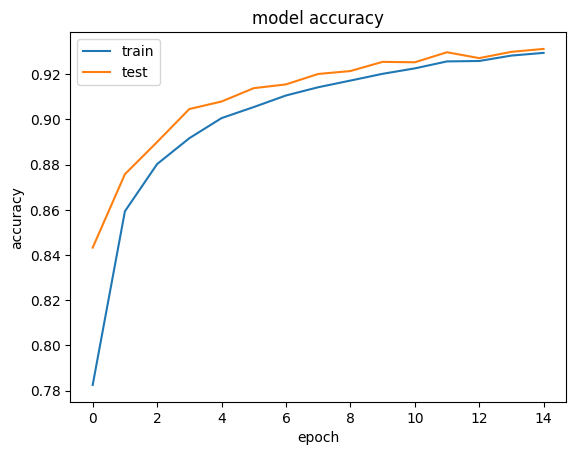

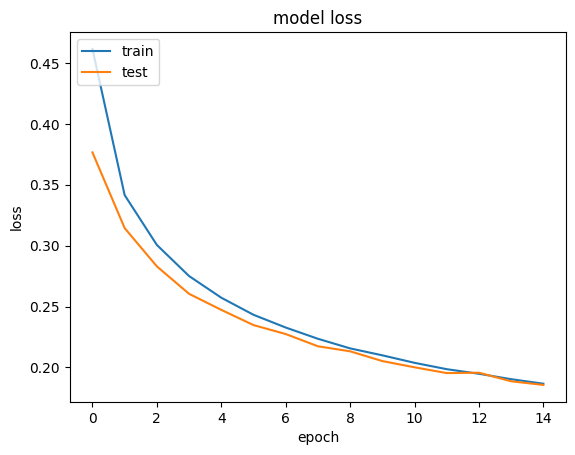

In [ ]:
impHistoria(history)

In [ ]:
test_loss, test_acc = model.evaluate(qx_resized, qy)
print("Test accuracy", test_acc); print("Test loss", test_loss)

326/326 [==============================] - 33s 96ms/step - loss: 0.1931 - accuracy: 0.9265
Test accuracy 0.9264635443687439
Test loss 0.1930747628211975


In [ ]:
#Libera todos layers do model (incluindo modelo-base) para treinar:
for layer in model.layers:
  layer.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),  # Taxa de aprendizado menor para ajuste fino
              loss='binary_crossentropy',
              metrics=['accuracy'])
steps_per_epoch = len(ax) // batch_size
history = model.fit(ax_resized, ay, epochs = 8, batch_size = batch_size, steps_per_epoch=steps_per_epoch, shuffle = True, validation_data=(vx_resized,vy))
model.save("resnet50_fine_tunning.h5")

Epoch 1/8
1357/1357 [==============================] - 294s 190ms/step - loss: 0.1265 - accuracy: 0.9512 - val_loss: 0.0455 - val_accuracy: 0.9841
Epoch 2/8
1357/1357 [==============================] - 258s 189ms/step - loss: 0.0283 - accuracy: 0.9905 - val_loss: 0.0424 - val_accuracy: 0.9849
Epoch 3/8
1357/1357 [==============================] - 257s 189ms/step - loss: 0.0132 - accuracy: 0.9965 - val_loss: 0.0628 - val_accuracy: 0.9777
Epoch 4/8
1357/1357 [==============================] - 252s 186ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 0.0321 - val_accuracy: 0.9904
Epoch 5/8
1357/1357 [==============================] - 252s 186ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.0392 - val_accuracy: 0.9863
Epoch 6/8
1357/1357 [==============================] - 253s 186ms/step - loss: 0.0057 - accuracy: 0.9986 - val_loss: 0.0618 - val_accuracy: 0.9799
Epoch 7/8
1357/1357 [==============================] - 253s 186ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


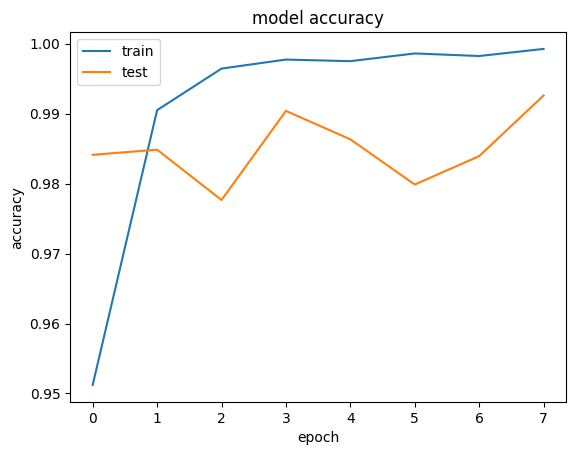

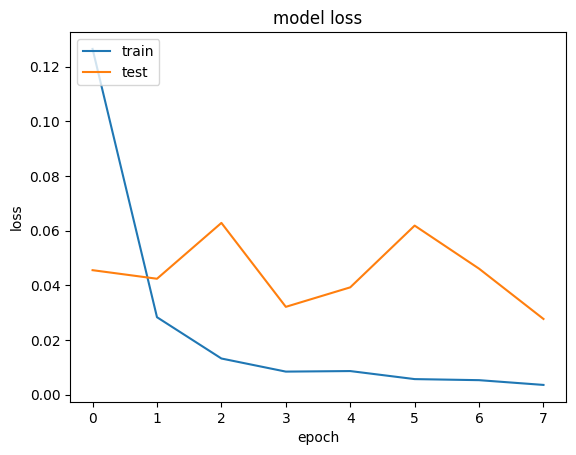

In [ ]:
impHistoria(history)

In [ ]:
test_loss, test_acc = model.evaluate(qx_resized, qy)
print("Test accuracy", test_acc); print("Test loss", test_loss)

326/326 [==============================] - 31s 94ms/step - loss: 0.0323 - accuracy: 0.9911
Test accuracy 0.9910602569580078
Test loss 0.03232492879033089


In [ ]:
y_predict = model.predict(qx_resized)

326/326 [==============================] - 33s 99ms/step


In [ ]:
y_pred = (y_predict >= 0.5).astype(int)
TP = np.sum(np.logical_and(qy == 1, y_pred == 1))
TN = np.sum(np.logical_and(qy == 0, y_pred == 0))
FP = np.sum(np.logical_and(qy == 0, y_pred == 1))
FN = np.sum(np.logical_and(qy == 1, y_pred == 0))

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensibilidade = ", sensitivity*100)
print("Especificidade = ", specificity*100)

Sensibilidade =  41.11314044025762
Especificidade =  58.886859559742376


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(qy, y_predict)
auc_score = auc(fpr, tpr)

print("AUC = ", 100*auc_score)

AUC =  99.93028393679859


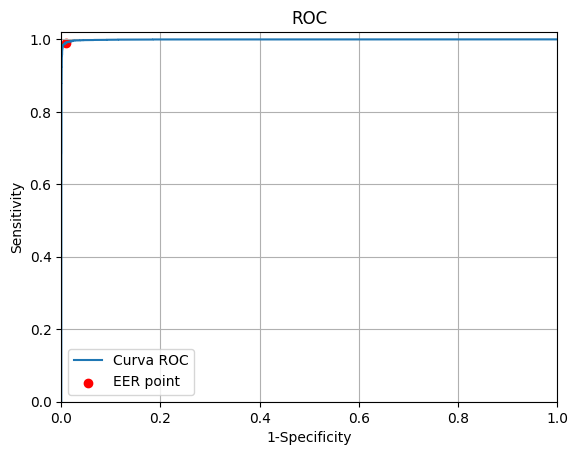

In [ ]:
plt.plot(fpr, tpr, label='Curva ROC')
eer_fpr = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
eer_tpr = tpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

plt.scatter(eer_fpr, eer_tpr, marker='o', color='red', label='EER point')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.02])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC')
plt.legend()
plt.grid()

In [ ]:
print(eer_tpr)

0.9906933457422057


In [ ]:
print(eer_fpr)

0.009336609336609337
